<a href="https://colab.research.google.com/github/AlfonsoVasquezC/ComputervisionMNA/blob/main/Rigo_7_2_2_Equipo_1_Google_Colab_algoritmos_de_extracci%C3%B3n_de_caracter%C3%ADsticas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

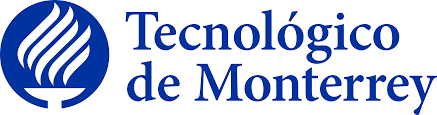

#**Maestría en Inteligencia Artificial Aplicada**
##**Curso: Visión computacional para imágenes y video**
###Tecnológico de Monterrey
###Dr. Gilberto Ochoa Ruiz

## 7.2 Google Colab algoritmos de extracción de características

**Por:**

* A01183284 RODRIGO RODRIGUEZ RODRIGUEZ
* A01793132 RIGOBERTO VEGA ESCUDERO
* A01016308 ALEXIS HERNANDEZ MARTINEZ
* A00820656 JUAN ALFONSO VASQUEZ CHAPOI
* A00759664 JOEL ORLANDO HERNANDEZ RAMOS

# 9. Image Matching

## Table of Contents
1. [Libraries](#libraries)
1. [ORB Matching](#orb)
1. [SIFT Matching](#sift)

## Importing Libraries <a class="anchor" id="libraries" ></a>

In [1]:
import cv2 
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# ORB (Oriented FAST and Rotated BRIEF) <a class="anchor" id="orb" ></a>

- Developed at OpenCV labs by Ethan Rublee, Vincent Rabaud, Kurt Konolige, and Gary R. Bradski in 2011
- Efficient and viable alternative to SIFT and SURF (patented algorithms)
- ORB is free to use
- Feature detection
- ORB builds on FAST keypoint detector + BRIEF descriptor

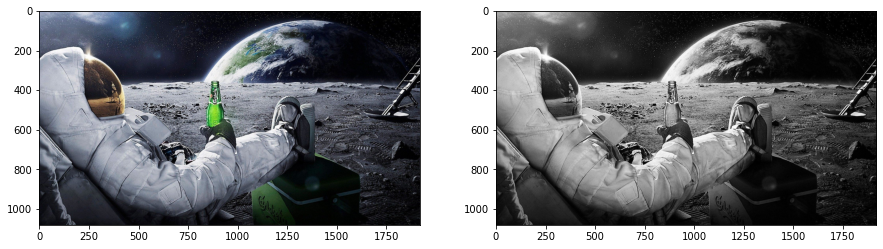

In [58]:
#reading image
img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/Computo imagen y video/7.2/Astro.jpg')  
img_color = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.imshow(img_color)
plt.subplot(1, 2, 2)
plt.imshow(img_gray, cmap="gray")

### Create test image by adding Scale Invariance and Rotational Invariance

In [59]:
test_image = cv2.pyrDown(img_color)
test_image = cv2.pyrDown(test_image)
num_rows, num_cols = test_image.shape[:2]

rotation_matrix = cv2.getRotationMatrix2D((num_cols/2, num_rows/2), 30, 1)
test_image = cv2.warpAffine(test_image, rotation_matrix, (num_cols, num_rows))

test_gray = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)

### Display traning image and testing image

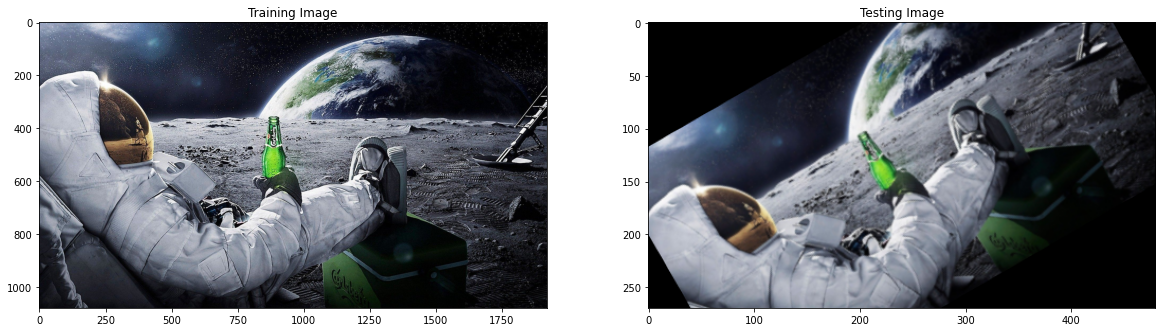

In [60]:
fx, plots = plt.subplots(1, 2, figsize=(20,10))

plots[0].set_title("Training Image")
plots[0].imshow(img_color)

plots[1].set_title("Testing Image")
plots[1].imshow(test_image)

### ORB

ORB es básicamente una fusión del detector de puntos clave RÁPIDO y el descriptor BREVE con muchas modificaciones para mejorar el rendimiento. Primero usa FAST para encontrar puntos clave, luego aplica la medida de la esquina de Harris para encontrar los N puntos principales entre ellos. También utiliza la pirámide para producir características multiescala. Pero un problema es que FAST no calcula la orientación. Entonces, ¿qué pasa con la invariancia de rotación? A los autores se les ocurrió la siguiente modificación.

Calcula el centroide ponderado por intensidad del parche con la esquina ubicada en el centro. La dirección del vector desde este punto de esquina hasta el centroide da la orientación. Para mejorar la invariancia de rotación, los momentos se calculan con x e y, que deben estar en una región circular de radio r, donde r es el tamaño del parche.

In [61]:
orb = cv2.ORB_create()

Number of Keypoints Detected In The Training Image:  500
Number of Keypoints Detected In The Query Image:  491


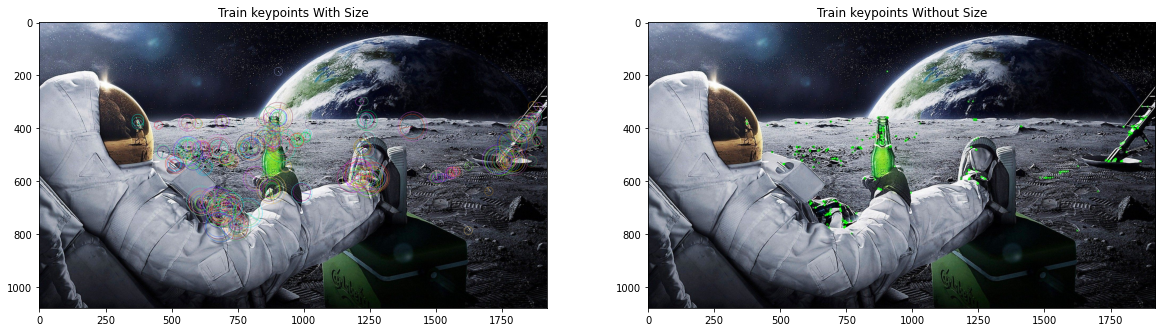

In [62]:
train_keypoints, train_descriptor = orb.detectAndCompute(img_color, None)
test_keypoints, test_descriptor = orb.detectAndCompute(test_gray, None)

keypoints_without_size = np.copy(img_color)
keypoints_with_size = np.copy(img_color)

cv2.drawKeypoints(img_color, train_keypoints, keypoints_without_size, color = (0, 255, 0))

cv2.drawKeypoints(img_color, train_keypoints, keypoints_with_size, flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display image with and without keypoints size
fx, plots = plt.subplots(1, 2, figsize=(20,10))

plots[0].set_title("Train keypoints With Size")
plots[0].imshow(keypoints_with_size, cmap='gray')

plots[1].set_title("Train keypoints Without Size")
plots[1].imshow(keypoints_without_size, cmap='gray')

# Print the number of keypoints detected in the training image
print("Number of Keypoints Detected In The Training Image: ", len(train_keypoints))

# Print the number of keypoints detected in the query image
print("Number of Keypoints Detected In The Query Image: ", len(test_keypoints))

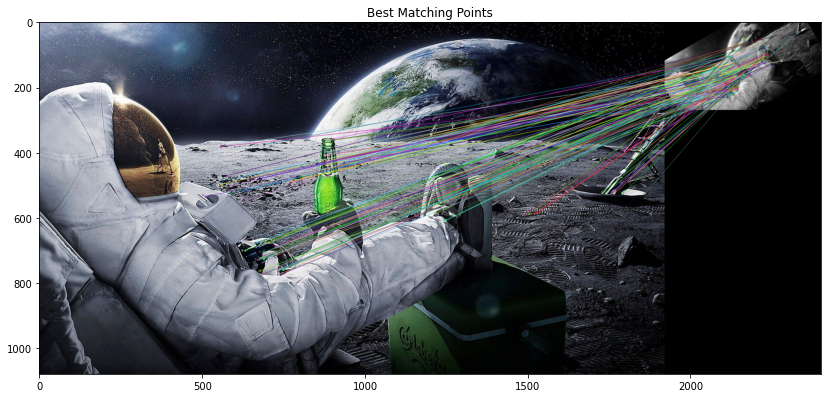


Number of Matching Keypoints Between The Training and Query Images:  141


In [63]:

# Create a Brute Force Matcher object.
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = True)

# Perform the matching between the ORB descriptors of the training image and the test image
matches = bf.match(train_descriptor, test_descriptor)

# The matches with shorter distance are the ones we want.
matches = sorted(matches, key = lambda x : x.distance)

result = cv2.drawMatches(img_color, train_keypoints, test_gray, test_keypoints, matches, test_gray, flags = 2)

# Display the best matching points
plt.rcParams['figure.figsize'] = [14.0, 7.0]
plt.title('Best Matching Points')
plt.imshow(result)
plt.show()

# Print total number of matching points between the training and query images
print("\nNumber of Matching Keypoints Between The Training and Query Images: ", len(matches))

## SIFT Matching (Scale Invariant Feature Transform) <a class="anchor" id="sift" ></a>

La transformación de características de escala invariable (SIFT) es un método de extracción de características ampliamente adoptado en las tareas de clasificación de imágenes. La característica es invariable a la escala y orientación de las imágenes y robusta a las fluctuaciones de iluminación, ruido, oclusión parcial y cambios menores en el punto de vista de las imágenes. Estas características son importantes para la detección de mitosis cuando las células de la imagen tienen diferentes tamaños y orientaciones. La función SIFT se compone de varios puntos clave en la imagen con una orientación y el descriptor correspondiente del área alrededor de los puntos clave seleccionados.

El objetivo de la detección y coincidencia de características es identificar un emparejamiento entre un punto en una imagen y un punto correspondiente en otra imagen. Estas correspondencias se pueden usar para unir varias imágenes en un panorama. La coincidencia de características se refiere a encontrar las características correspondientes de dos imágenes similares en función de un algoritmo de distancia de búsqueda. Una de las imágenes se considera el origen y la otra el destino, y la técnica de coincidencia de características se utiliza para buscar o derivar y transferir atributos de la imagen de origen a la de destino. El proceso de coincidencia de funciones generalmente analiza la topología de la imagen de origen y destino, detecta los patrones de funciones, hace coincidir los patrones y hace coincidir las funciones dentro de los patrones descubiertos. La precisión de la coincidencia de características depende de la similitud, la complejidad y la calidad de la imagen. Normalmente, se puede lograr un alto porcentaje de coincidencia exitosa usando el método correcto, mientras que pueden ocurrir incertidumbres y errores y requerirían una inspección posterior y correcciones.

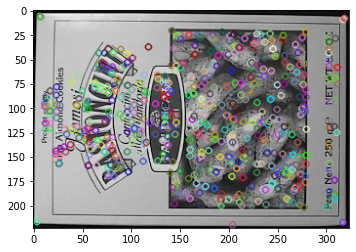

In [39]:
img1 = cv2.imread('/content/drive/MyDrive/Colab Notebooks/Computo imagen y video/7.2/box1.png')  
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

#keypoints
sift = cv2.SIFT_create()
keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)

img_1 = cv2.drawKeypoints(gray1,keypoints_1,img1)
plt.imshow(img_1)

### Matching different images

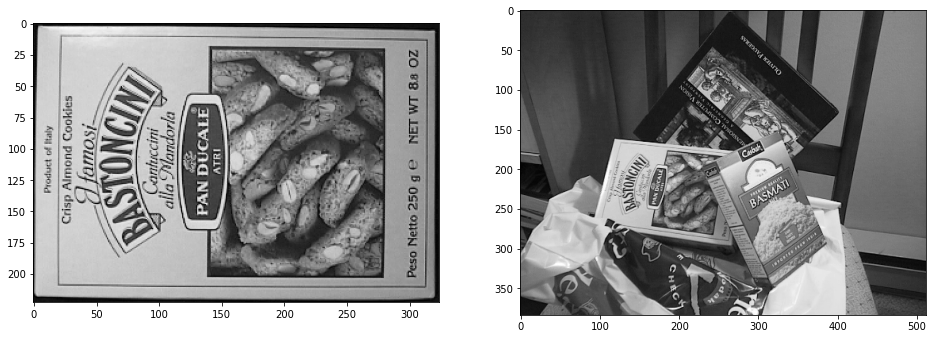

In [40]:
# read images
img1 = cv2.imread('/content/drive/MyDrive/Colab Notebooks/Computo imagen y video/7.2/box1.png')  
img2 = cv2.imread('/content/drive/MyDrive/Colab Notebooks/Computo imagen y video/7.2/box2.png') 

img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

figure, ax = plt.subplots(1, 2, figsize=(16, 8))

ax[0].imshow(img1, cmap='gray')
ax[1].imshow(img2, cmap='gray')

### Extracting Keypoints with SIFT

In [41]:
#sift
sift = cv2.SIFT_create()

keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)
keypoints_2, descriptors_2 = sift.detectAndCompute(img2,None)

len(keypoints_1), len(keypoints_2)

(604, 969)

### Feature Matching

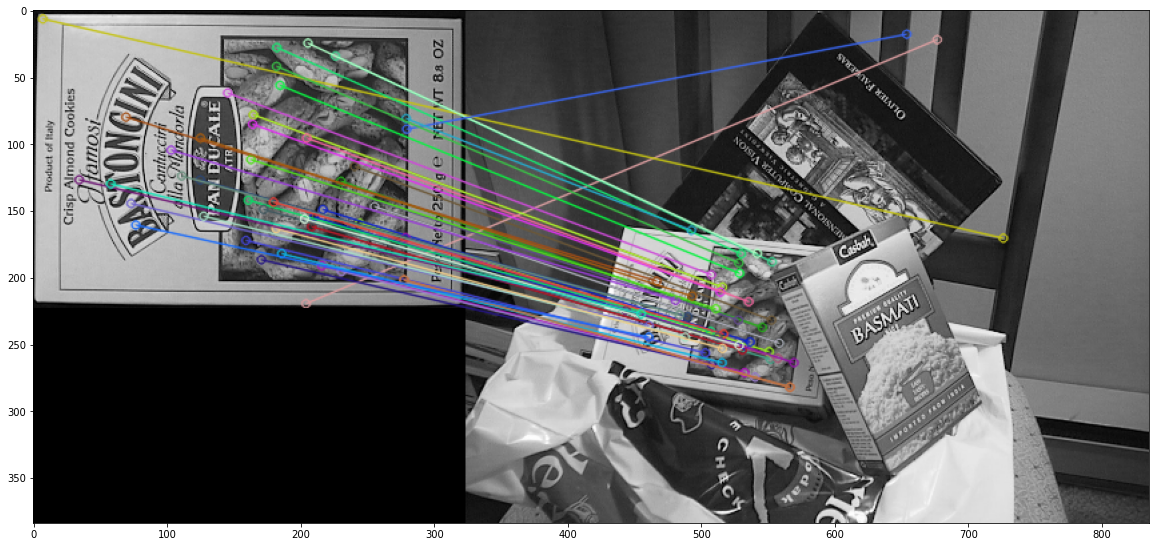

(<matplotlib.image.AxesImage at 0x7f10628a6730>, None)

In [44]:
#feature matching
fx, plots = plt.subplots(1, 1, figsize=(20,10))
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

matches = bf.match(descriptors_1,descriptors_2)
matches = sorted(matches, key = lambda x:x.distance)

img3 = cv2.drawMatches(img1, keypoints_1, img2, keypoints_2, matches[:50], img2, flags=2)
plt.imshow(img3),plt.show()

#Conclusiones.

Tanto Orb como Sift funcionaron adecuadamente para la detección de características similares en las imágenes, pero cuando se trabajó con ORB notamos que el algoritmo batalla más en encontrar las coincidencias cuando las imágenes son de baja calidad, es por ello que se optó por el uso de imágenes HD para poder utilizar el algoritmo apropiadamente. Pero con Sift con imágenes de más baja calidad encontrar las coincidencias fue más sencillo.

#Referencias

- DEY, V. (2021, 07 07). Introduction To Local Feature Matching Using LoFTR. Retrieved from https://analyticsindiamag.com/introduction-to-local-feature-matching-using-loftr/#:~:text=Feature%20matching%20refers%20to%20finding,from%20source%20to%20target%20image.


- Gonzalez, R. & Woods, R. (2018). Digital Image Processing. 4° Edition. 
Pearson.

- Javaheri, B. (2022, 03 24). Feature extraction and image classification using Deep Neural Networks and OpenCV. Retrieved from https://www.dominodatalab.com/blog/feature-extraction-and-image-classification-using-deep-neural-networks

- OpenCV. (2023). Feature Detection and Description. Retrieved from https://docs.opencv.org/3.4/db/d27/tutorial_py_table_of_contents_feature2d.html

- Ruiz, G. O. (2023). Módulo 3.2: Extracción de Descriptores. 

- Yao Lu, An-An Liu, Yu-Ting Su, Chapter 6 - Mitosis detection in biomedical images, Editor(s): Mei Chen, In Computer Vision and Pattern Recognition, Computer Vision for Microscopy Image Analysis, Academic Press, 2021, Pages 131-157, ISBN 9780128149720, https://doi.org/10.1016/B978-0-12-814972-0.00006-0.

